# Install and Load Libraries/Data

In [16]:
#!pip install skorch

In [17]:
import random
import torch # type: ignore
import numpy as np  # type: ignore
import pandas as pd # type: ignore
from torch import nn # type: ignore
from skorch import NeuralNetClassifier # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.model_selection import train_test_split, GridSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer # type: ignore
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.metrics import cohen_kappa_score, make_scorer

# Set the seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [18]:
# Paths to data folders
#train_csv_path = './data/merged_train.csv'
#test_csv_path = './data/merged_test.csv'

train_csv_path = './data/processed_train_df.csv'
test_csv_path = './data/processed_test_df.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Splitting and Scaling/OneHotEncoding

In [19]:
# Separate features and target from the training data
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)   # Ensure the target is integer-encoded

# Test data (features only)
X_test = test_df.drop(columns=['id'])

In [20]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [21]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [22]:
# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale features
])

# Define preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encode
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Define a transformer to convert the output to float32
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

# Fitting Skorch NN

In [23]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=4, nonlin=nn.ReLU(), dropout=0.0):
        super(MyModule, self).__init__()
        layers = []
        layer_sizes = [inp_size] + hidden_sizes

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nonlin)
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
        
        # Output layer (without activation function)
        layers.append(nn.Linear(layer_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X)

In [24]:
# Determine the number of input features after preprocessing
preprocessor.fit(X_train)
num_input_features = preprocessor.transform(X_train[:1]).shape[1]  # Use a small sample to get the shape

# Define the Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=MyModule,
    module__inp_size=num_input_features,
    module__hidden_sizes=[128, 64],
    module__nonlin=nn.ReLU(),    # Default activation function
    module__dropout=0.5,         # Default dropout rate
    max_epochs=100,
    lr=0.001,
    optimizer=torch.optim.Adam,  # Default optimizer
    criterion=torch.nn.CrossEntropyLoss(),
    batch_size=256,
    iterator_train__shuffle=True,
    verbose=1,
)

# Create a Pipeline that includes preprocessing, casting to float32, and the neural network
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', to_float32),
    ('nn', net)
])

In [25]:
params = [
    # Parameters for Adam optimizer
    {
        'nn__lr': [0.01, 0.001],
        'nn__max_epochs': [20, 50],
        'nn__module__hidden_sizes': [[128, 64], [64, 32]],
        'nn__module__nonlin': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()],
        'nn__module__dropout': [0.0, 0.5],
        'nn__optimizer': [torch.optim.Adam],
    },
    # Parameters for SGD optimizer with momentum
    {
        'nn__lr': [0.01, 0.001],
        'nn__max_epochs': [20, 50],
        'nn__module__hidden_sizes': [[128, 64], [64, 32]],
        'nn__module__nonlin': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()],
        'nn__module__dropout': [0.0, 0.5],
        'nn__optimizer': [torch.optim.SGD],
        'nn__optimizer__momentum': [0.0, 0.9],
    },
]

In [26]:
kappa_scorer = make_scorer(cohen_kappa_score)

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=10,                     # 10-fold cross-validation
    scoring=kappa_scorer,      # Use kappa_scorer as the scoring metric
    refit=True,                # Refit the model with the best parameters
    verbose=2,                 # Verbosity level
    n_jobs=-1                  # Utilize all available cores
)

gs.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2663       0.7603        1.0949  0.1476
      2        0.9263       0.7729        0.7431  0.1431
      3        0.6151       0.8438        0.5083  0.1417
      4        0.4380       0.8549        0.4017  0.1361
      5        0.3570       0.8927        0.3495  0.1436
      6        0.3119       0.9290        0.3150  0.1308
      7        0.2815       0.9338        0.2911  0.1324
      8        0.2573       0.9353        0.2728  0.1347
      9        0.2380       0.9385        0.2567  0.1312
     10        0.2214       0.9527        0.2432  0.1322
     11        0.2062       0.9479        0.2314  0.1305
     12        0.1934       0.9495        0.2208  0.1391
     13        0.1812       0.9495        0.2112  0.1277
     14        0.1717       0.9464        0.2036  0.1294
     15        0.1603  

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Basic_Demos-Age',
                                                                          'CGAS-CGAS_Score',
                                                                          'Physical-BMI',
                                                                          'Physical-Height',
                                                                          'Physical-Weight',
                                                                          'Physical-Waist_Circumference',
                                                                          'Physical-Diastolic_BP',
                                                                          'Physical-HeartRate',
                                                                          'Physical-Systolic_BP',
                                                                          'Fitness_Enduranc...
                         {'nn__lr': [0.01, 0.001], 'nn__max_epochs': [20, 50],
                          'nn__module__dropout': [0.0, 0.5],
                          'nn__module__hidden_sizes': [[128, 64], [64, 32]],
                          'nn__module__nonlin': [ReLU(),
                                                 LeakyReLU(negative_slope=0.01),
                                                 ELU(alpha=1.0)],
                          'nn__optimizer': [<class 'torch.optim.sgd.SGD'>],
                          'nn__optimizer__momentum': [0.0, 0.9]}],
             scoring=make_scorer(cohen_kappa_score, response_method='predict'),
             verbose=2)

# Evaluating Skorch NN

In [27]:
# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation Accuracy: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")

# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_


Best Cross-Validation Accuracy: 0.9277
Best Parameters: {'nn__lr': 0.01, 'nn__max_epochs': 50, 'nn__module__dropout': 0.0, 'nn__module__hidden_sizes': [64, 32], 'nn__module__nonlin': ELU(alpha=1.0), 'nn__optimizer': <class 'torch.optim.sgd.SGD'>, 'nn__optimizer__momentum': 0.9}


In [28]:
# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9646

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       563
           1       0.93      0.93      0.93       146
           2       0.87      0.91      0.89        76
           3       0.67      0.29      0.40         7

    accuracy                           0.96       792
   macro avg       0.86      0.78      0.80       792
weighted avg       0.96      0.96      0.96       792



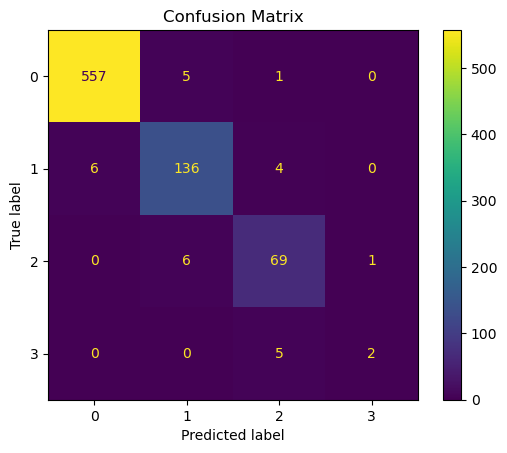

In [29]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Make predictions on the test set
#y_test_pred = best_pipeline.predict(X_test)

# Save the predictions to a file
#output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred})
#output_df.to_csv('test_predictions.csv', index=False)